In [1]:
#Import libraries
import pandas as pd
import geopandas as gpd
import geopandas as gpd
import geopandas.tools
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [2]:
# Load the dataset
df = pd.read_csv("../data/realistic_climate_change_impacts.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Show the first few rows
display(df.head())

# Structure of the data
df.info()

# Statistical summary
df.describe()

# Column names
print(df.columns.tolist())

# Count nulls
print("Null values:\n", df.isnull().sum())

# Show value counts of extreme weather events
print("Extreme Weather Event Counts:\n", df["extremeweatherevent"].value_counts())


,recordid,date,country,temperatureanomaly_c,co2level_ppm,extremeweatherevent,economicimpact_usd,populationaffected
0,07cecceb-69e6-47eb-a19b-34d6824cdea8,11/17/2019,India,-0.15,410.44,Drought,"8,630,289.48",375036
1,a6e7e2a5-00ea-4af2-b151-a1a63386e436,5/18/2014,Australia,-0.03,376.37,Tornado,"1,379,227.03",274952
2,6890cfe8-21d3-4c0d-9b6a-e543e308c06e,4/15/2002,Japan,0.55,362.97,Wildfire,"1,093,567.72",4422930
3,ac61117f-9b84-4327-be46-67a8d84bca24,10/13/2013,India,-0.51,396.67,Flood,"5,260,336.62",2122860
4,2df860a5-07e4-4832-a344-ae198276cdb8,10/15/2020,USA,1.78,367.59,Wildfire,"4,567,592.01",2433756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recordid              10000 non-null  object 
 1   date                  10000 non-null  object 
 2   country               10000 non-null  object 
 3   temperatureanomaly_c  10000 non-null  float64
 4   co2level_ppm          10000 non-null  float64
 5   extremeweatherevent   8616 non-null   object 
 6   economicimpact_usd    10000 non-null  object 
 7   populationaffected    10000 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 625.1+ KB
['recordid', 'date', 'country', 'temperatureanomaly_c', 'co2level_ppm', 'extremeweatherevent', 'economicimpact_usd', 'populationaffected']
Null values:
 recordid                   0
date                       0
country                    0
temperatureanomaly_c       0
co2level_ppm               0
extremeweatherevent  

In [3]:
# Step 1: Convert economic impact from string to float
df["economicimpact_usd"] = df["economicimpact_usd"].str.replace(",", "")
df["economicimpact_usd"] = pd.to_numeric(df["economicimpact_usd"], errors="coerce")

# Step 2: Convert date column to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Step 3: Check how many nulls still remain
print("Nulls after conversion:\n", df.isnull().sum())

# Step 4: Preview data types
print("\nData types after cleaning:")
print(df.dtypes)


Nulls after conversion:
 recordid                   0
date                       0
country                    0
temperatureanomaly_c       0
co2level_ppm               0
extremeweatherevent     1384
economicimpact_usd         0
populationaffected         0
dtype: int64

Data types after cleaning:
recordid                        object
date                    datetime64[ns]
country                         object
temperatureanomaly_c           float64
co2level_ppm                   float64
extremeweatherevent             object
economicimpact_usd             float64
populationaffected               int64
dtype: object


In [4]:
# Step 5:  Fill missing event types with 'Unknown'
df["extremeweatherevent"] = df["extremeweatherevent"].fillna("Unknown")

# Confirm fix
df["extremeweatherevent"].value_counts()


extremeweatherevent
Hurricane    1477
Flood        1461
Tornado      1434
Drought      1431
Heatwave     1422
Wildfire     1391
Unknown      1384
Name: count, dtype: int64

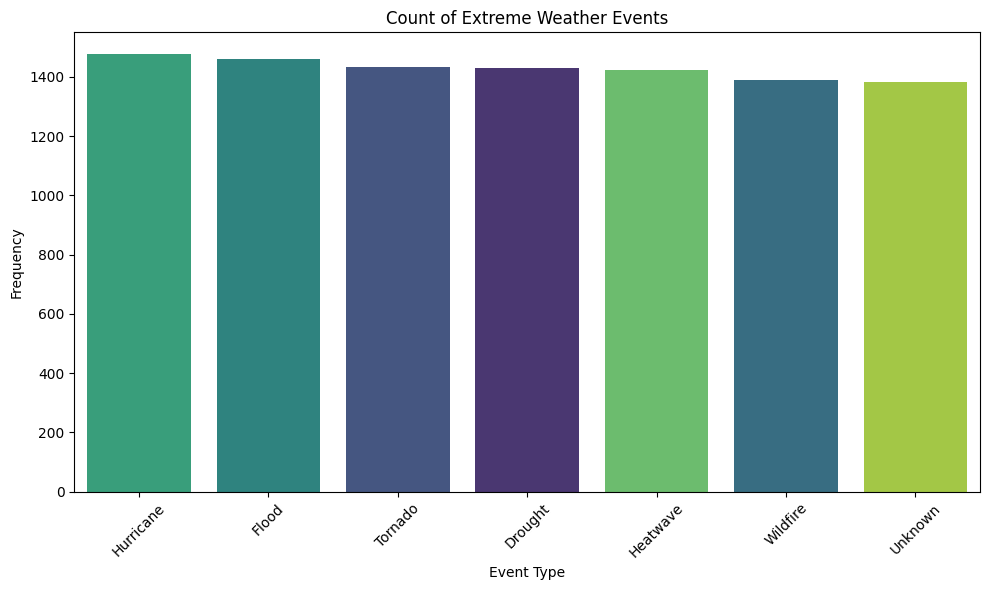

In [5]:
#STEP 6.1 — Top Extreme Weather Events (Bar Chart)
#This will show you how many occurrences of each event type exist in your dataset.
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="extremeweatherevent",
    order=df["extremeweatherevent"].value_counts().index,
    palette="viridis",
    hue="extremeweatherevent",
    legend=False
)
plt.title("Count of Extreme Weather Events")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


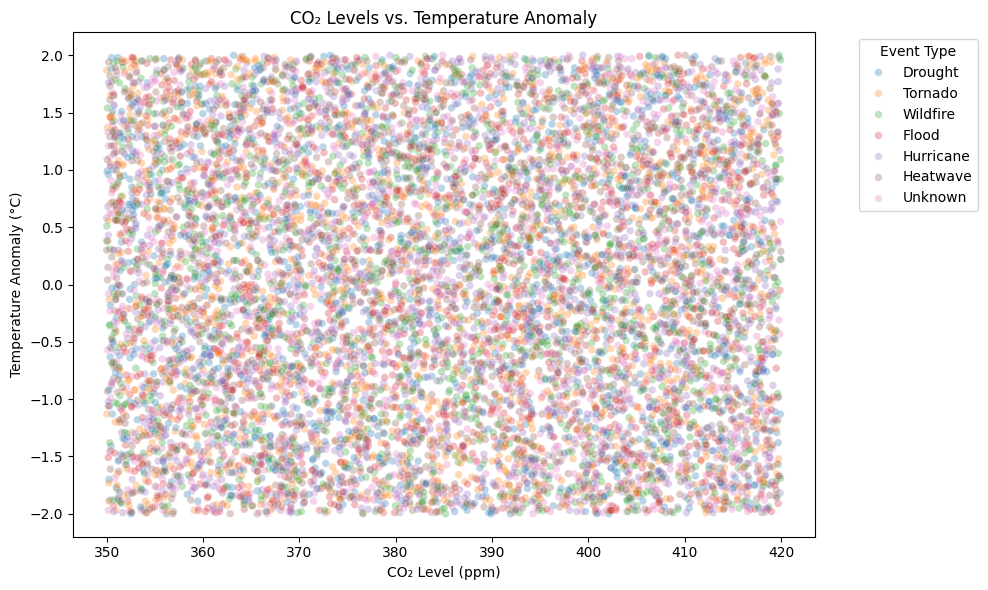

In [6]:
#STEP 6.2 — CO₂ vs Temperature Anomaly (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="co2level_ppm",
    y="temperatureanomaly_c",
    hue="extremeweatherevent",
    alpha=0.3,   # more transparent
    s=30         # smaller dots
)
plt.title("CO₂ Levels vs. Temperature Anomaly")
plt.xlabel("CO₂ Level (ppm)")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


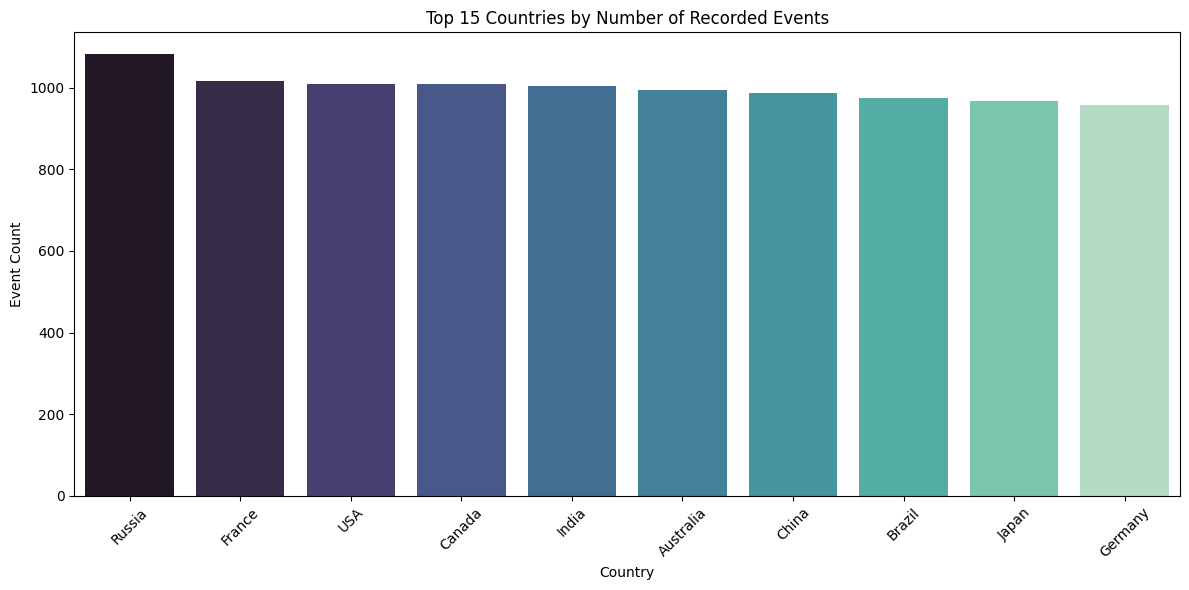

In [7]:
# Next: STEP 6.3 — Top Countries by Event Count
plt.figure(figsize=(12, 6))
top_countries = df["country"].value_counts().head(15).reset_index()
top_countries.columns = ["country", "count"]

sns.barplot(
    data=top_countries,
    x="country",
    y="count",
    hue="country",
    palette="mako",
    legend=False
)
plt.title("Top 15 Countries by Number of Recorded Events")
plt.ylabel("Event Count")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



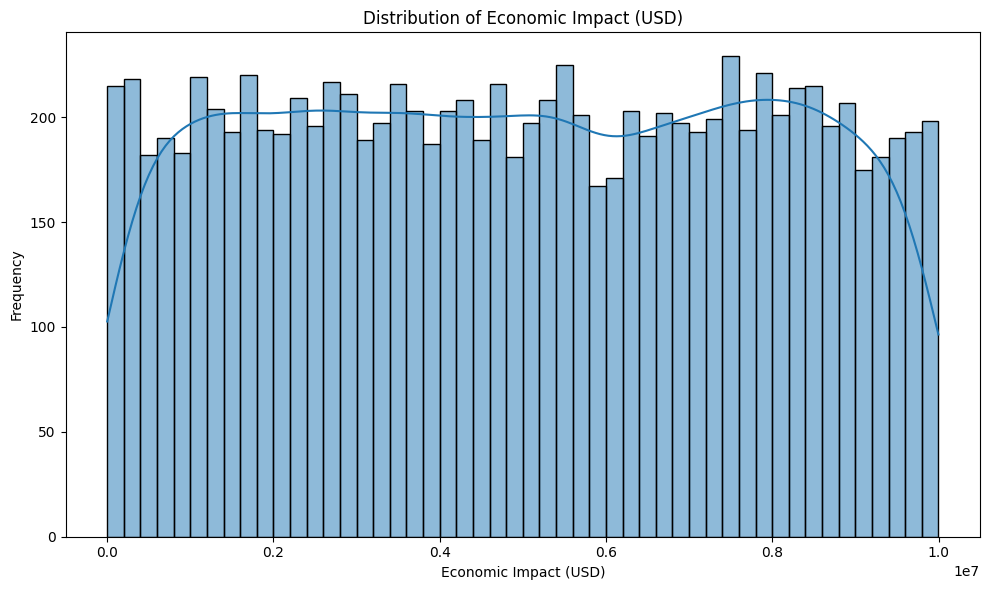

In [8]:
#Next: STEP 6.4 — Economic Impact Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["economicimpact_usd"], bins=50, kde=True)
plt.title("Distribution of Economic Impact (USD)")
plt.xlabel("Economic Impact (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

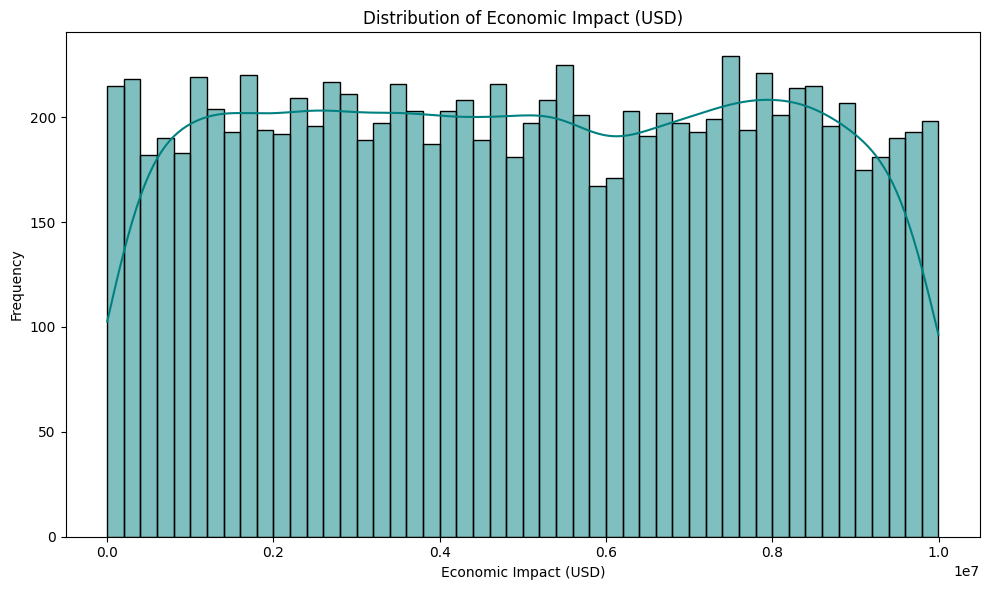

In [9]:
#STEP 6.4 — Distribution of Economic Impact (USD)
plt.figure(figsize=(10, 6))
sns.histplot(df["economicimpact_usd"], bins=50, kde=True, color="teal")
plt.title("Distribution of Economic Impact (USD)")
plt.xlabel("Economic Impact (USD)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Final EDA Step: STEP 6.5 — Correlation Heatmap
This shows relationships between:
- co2level_ppm
- temperatureanomaly_c
- economicimpact_usd
- populationaffected
- It helps detect:
- Redundancy
- Potential features for ML
- Unexpected relationships

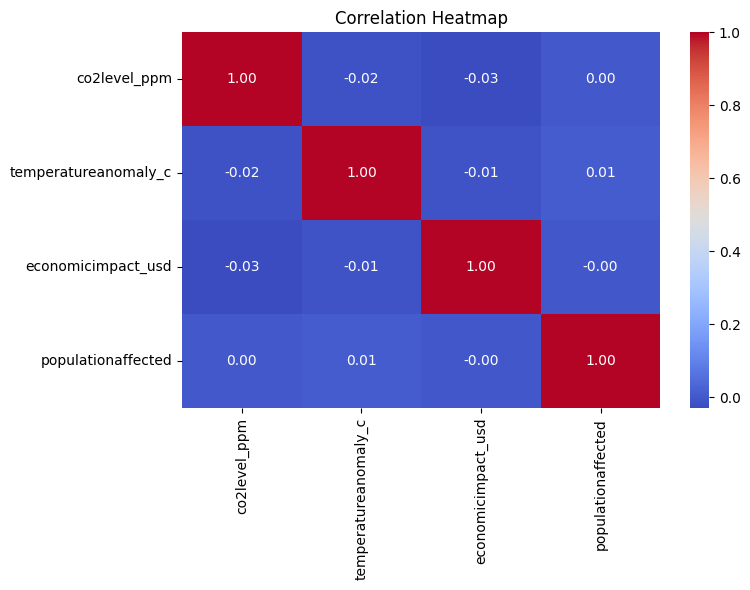

In [10]:
#STEP 6.5 — Correlation Heatmap
import numpy as np

# Select only numeric columns
corr_matrix = df[["co2level_ppm", "temperatureanomaly_c", "economicimpact_usd", "populationaffected"]].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


## Feature Engineering & Clustering (Unsupervised ML)


In [11]:
# STEP 1: Select and Scale Numeric Features
# Select features for clustering
features = df[["co2level_ppm", "temperatureanomaly_c", "economicimpact_usd", "populationaffected"]]

# Print the original features
print("Original Features:")
print(features.head())

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features to a DataFrame for readability
import pandas as pd
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Print the scaled features
print("\nScaled Features:")
print(scaled_features_df.head())

# Check the mean and standard deviation of scaled features
print("\nMean of Scaled Features:")
print(scaled_features_df.mean())

print("\nStandard Deviation of Scaled Features:")
print(scaled_features_df.std())


Original Features:
   co2level_ppm  temperatureanomaly_c  economicimpact_usd  populationaffected
0        410.44                 -0.15          8630289.48              375036
1        376.37                 -0.03          1379227.03              274952
2        362.97                  0.55          1093567.72             4422930
3        396.67                 -0.51          5260336.62             2122860
4        367.59                  1.78          4567592.01             2433756

Scaled Features:
   co2level_ppm  temperatureanomaly_c  economicimpact_usd  populationaffected
0      1.270000             -0.127466            1.267148           -1.459455
1     -0.423907             -0.023243           -1.247268           -1.528629
2     -1.090134              0.480502           -1.346324            1.338285
3      0.585377             -0.440135            0.098566           -0.251430
4     -0.860435              1.548788           -0.141654           -0.036551

Mean of Scaled Features:
c

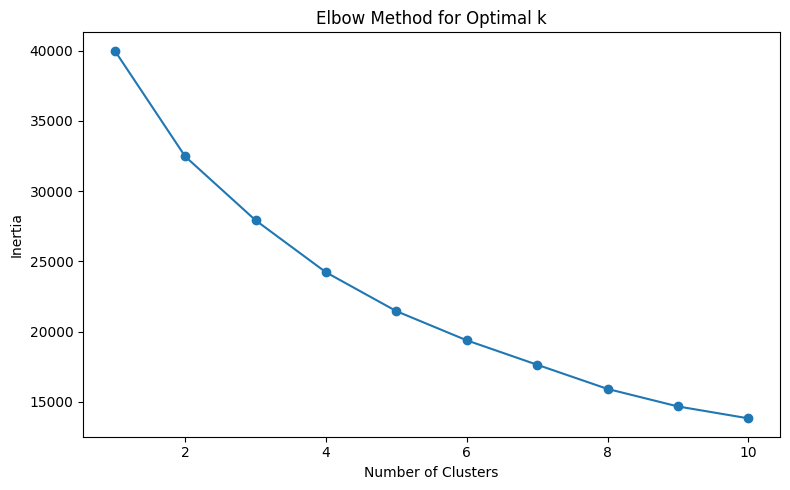

In [12]:
#STEP 2: Choose Optimal Number of Clusters (Elbow Method)
inertia = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()


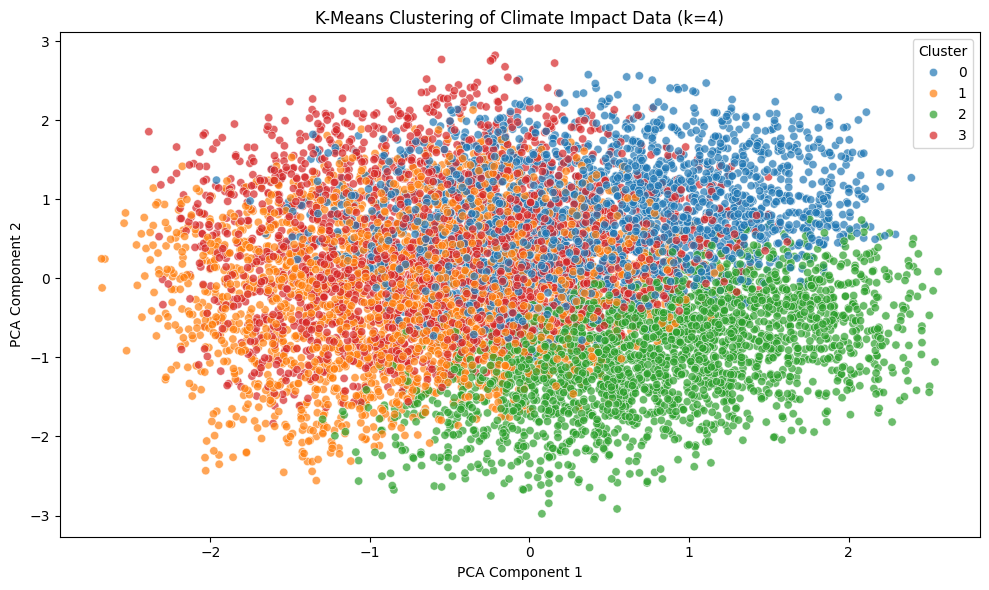

In [13]:
# STEP 3: Train Final K-Means Model (k=4)
# Train the KMeans model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled_features)

# STEP 4: Visualize the Clusters (2D Scatter)
# Using PCA to reduce dimensionality for plotting.

# Reduce to 2D for plotting
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

# Add to dataframe
df["pca_x"] = components[:, 0]
df["pca_y"] = components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("K-Means Clustering of Climate Impact Data (k=4)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [14]:
#What Do the Clusters Represent?
df.groupby("cluster")[["co2level_ppm", "temperatureanomaly_c", "economicimpact_usd", "populationaffected"]].mean()


,co2level_ppm,temperatureanomaly_c,economicimpact_usd,populationaffected
cluster,,,,
0,400.367893,1.085061,4.849181e+06,2.921743e+06
1,368.655358,0.263478,5.229844e+06,1.144426e+06
2,402.083218,-1.028838,4.686451e+06,2.058072e+06
3,369.115227,-0.303728,5.132812e+06,3.822805e+06


In [15]:
# Save the scaler and clustering model
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(kmeans, "../models/clustering_model.pkl")


['../models/clustering_model.pkl']

## Classification Phase (Supervised ML)
Goal: Predict event severity or type using climate data.
You’ll train a model like Random Forest to classify events based on:

CO₂ levels

Temperature anomaly

Economic impact

Population affected


In [16]:
# STEP 1: Define the Target and Features
# Prepare features and target
X = df[["co2level_ppm", "temperatureanomaly_c", "economicimpact_usd", "populationaffected"]]
y = df["extremeweatherevent"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# STEP 2: Train a Random Forest Classifier
# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
RandomForestClassifier(random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(clf.estimators_)  # Should return a list of fitted decision trees
print(len(clf.estimators_))  # Should match n_estimators (100 in this case)
predictions = clf.predict(X_test)  # Or use a subset of X_train for validation
print(predictions)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
clf.fit(X_train, y_train)
# After training
print(clf.estimators_)  # List of fitted decision trees
print(len(clf.estimators_))  # Should be 100
predictions = clf.predict(X_test)
print(predictions)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")  # Should be a reasonable value


X_train shape: (8000, 4)
y_train shape: (8000,)
[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542), DecisionTreeClassifier(max_features='sqrt', random_state=1273642419), DecisionTreeClassifier(max_features='sqrt', random_state=1935803228), DecisionTreeClassifier(max_features='sqrt', random_state=787846414), DecisionTreeClassifier(max_features='sqrt', random_state=996406378), DecisionTreeClassifier(max_features='sqrt', random_state=1201263687), DecisionTreeClassifier(max_features='sqrt', random_state=423734972), DecisionTreeClassifier(max_features='sqrt', random_state=415968276), DecisionTreeClassifier(max_features='sqrt', random_state=670094950), DecisionTreeClassifier(max_features='sqrt', random_state=1914837113), DecisionTreeClassifier(max_features='sqrt', random_state=669991378), DecisionTreeClassifier(max_features='sqrt', random_state=429389014), DecisionTreeClassifier(max_features='sqrt', random_state=249467210), DecisionTreeClassifier(max_features='sqrt', rando

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s


[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542), DecisionTreeClassifier(max_features='sqrt', random_state=1273642419), DecisionTreeClassifier(max_features='sqrt', random_state=1935803228), DecisionTreeClassifier(max_features='sqrt', random_state=787846414), DecisionTreeClassifier(max_features='sqrt', random_state=996406378), DecisionTreeClassifier(max_features='sqrt', random_state=1201263687), DecisionTreeClassifier(max_features='sqrt', random_state=423734972), DecisionTreeClassifier(max_features='sqrt', random_state=415968276), DecisionTreeClassifier(max_features='sqrt', random_state=670094950), DecisionTreeClassifier(max_features='sqrt', random_state=1914837113), DecisionTreeClassifier(max_features='sqrt', random_state=669991378), DecisionTreeClassifier(max_features='sqrt', random_state=429389014), DecisionTreeClassifier(max_features='sqrt', random_state=249467210), DecisionTreeClassifier(max_features='sqrt', random_state=1972458954), DecisionTreeClassifier(max_

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [18]:
#STEP 3: Evaluate the Model
# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Classification Report:
               precision    recall  f1-score   support

     Drought       0.12      0.12      0.12       294
       Flood       0.14      0.17      0.15       290
    Heatwave       0.13      0.15      0.14       279
   Hurricane       0.14      0.13      0.14       305
     Tornado       0.15      0.16      0.16       279
     Unknown       0.15      0.13      0.14       278
    Wildfire       0.13      0.12      0.12       275

    accuracy                           0.14      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.14      0.14      0.14      2000

Confusion Matrix:
 [[35 47 63 45 41 23 40]
 [44 48 43 45 35 36 39]
 [48 52 41 40 40 27 31]
 [39 57 45 40 47 42 35]
 [37 45 44 39 44 36 34]
 [41 49 33 39 38 36 42]
 [44 39 43 39 41 37 32]]


In [19]:
# STEP 4: Evaluate Your Classifier
# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Accuracy overview
print("Accuracy Score:", accuracy_score(y_test, y_pred))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Classification Report:

              precision    recall  f1-score   support

     Drought       0.12      0.12      0.12       294
       Flood       0.14      0.17      0.15       290
    Heatwave       0.13      0.15      0.14       279
   Hurricane       0.14      0.13      0.14       305
     Tornado       0.15      0.16      0.16       279
     Unknown       0.15      0.13      0.14       278
    Wildfire       0.13      0.12      0.12       275

    accuracy                           0.14      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.14      0.14      0.14      2000

Confusion Matrix:

[[35 47 63 45 41 23 40]
 [44 48 43 45 35 36 39]
 [48 52 41 40 40 27 31]
 [39 57 45 40 47 42 35]
 [37 45 44 39 44 36 34]
 [41 49 33 39 38 36 42]
 [44 39 43 39 41 37 32]]
Accuracy Score: 0.138


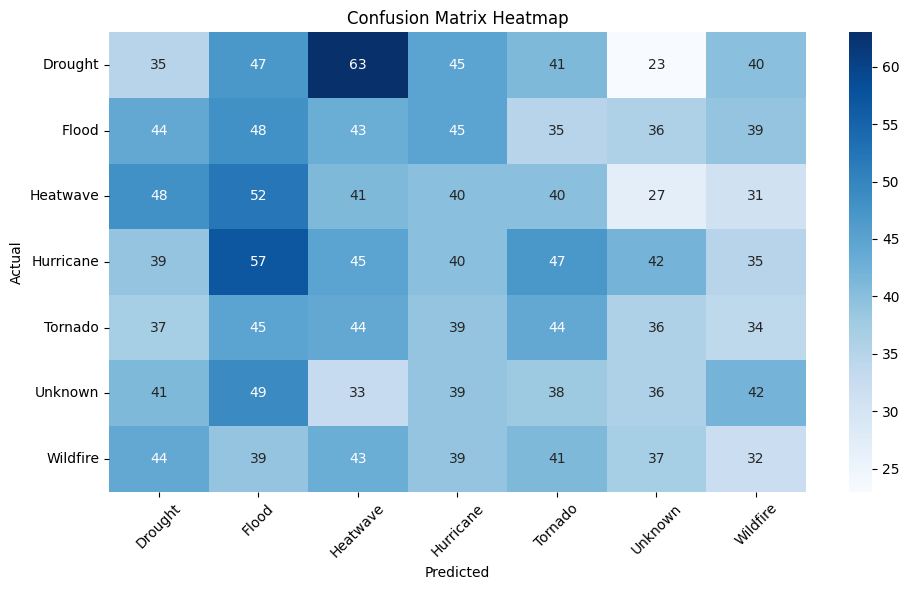

In [20]:
# STEP 5: Visualize the Confusion Matrix (Heatmap)
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# Step 6: Save the Model for Deployment
joblib.dump(clf, "../models/classification_model.pkl")


['../models/classification_model.pkl']


##  Step 7: Additional Insights and Advanced Visualizations
## Additional Insights: Feature Importance, Geo Map, and WordCloud

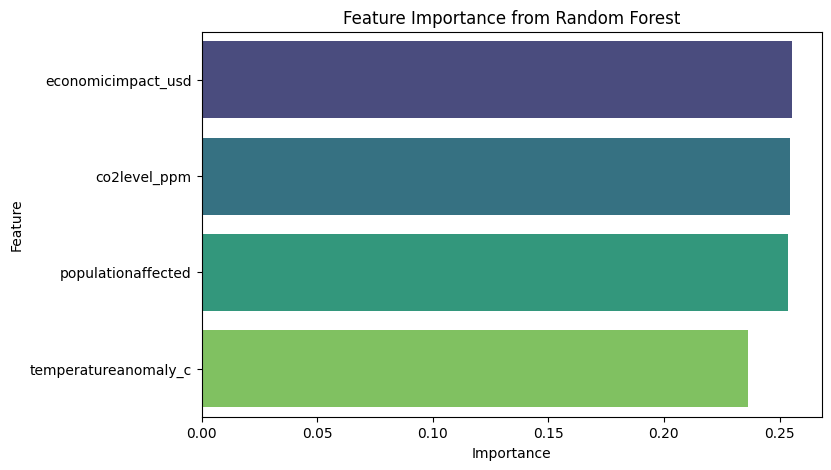

In [22]:
# Step 7.1: Additional Insights and Advanced Visualizations
# 1. Feature Importance from Random Forest

# Feature Importance
importances = clf.feature_importances_
features = ["co2level_ppm", "temperatureanomaly_c", "economicimpact_usd", "populationaffected"]

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', legend=False)
plt.title("Feature Importance from Random Forest")
plt.show()


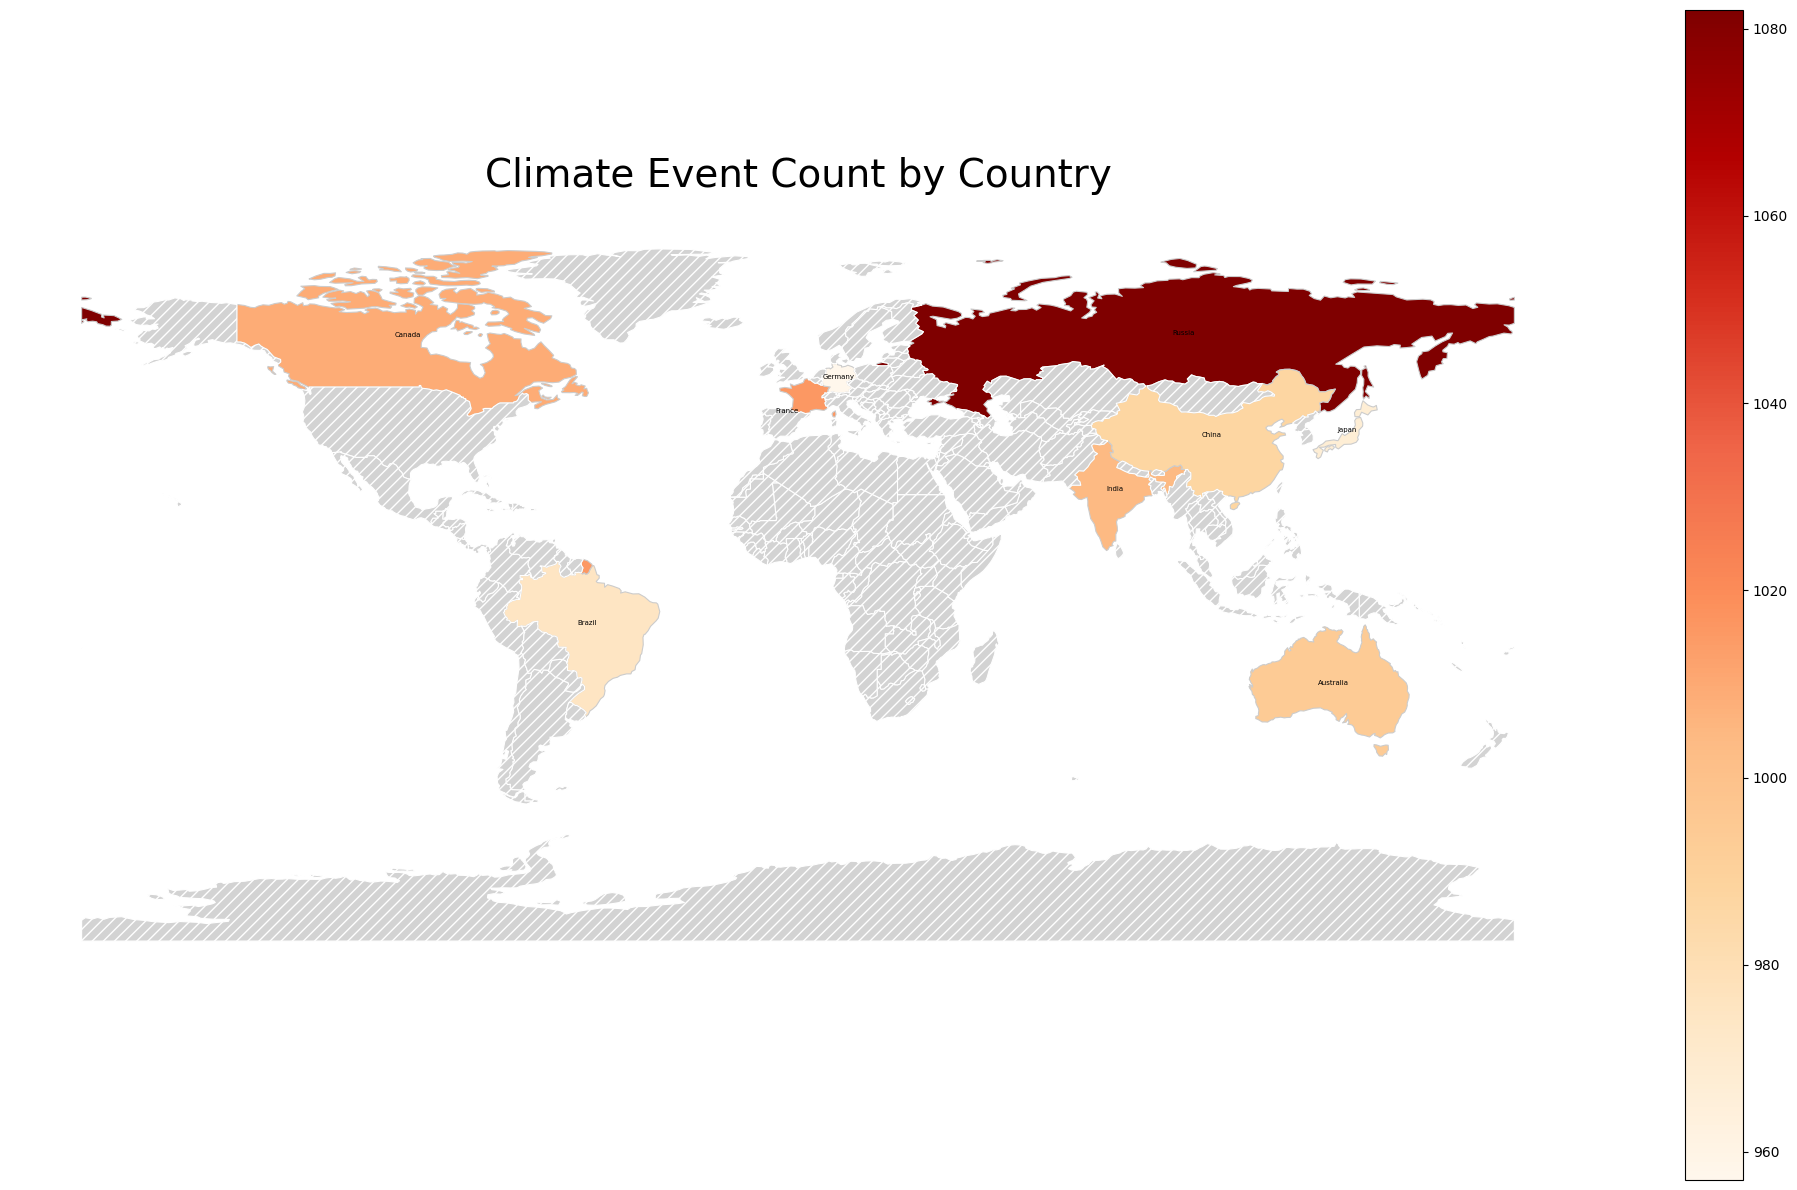

In [23]:
#  7.2. Country-Level Event Map using GeoPandas
# Map of event count per country

# Load shapefile
world = gpd.read_file('../data/ne_110m_admin_0_countries.shp')

# Group event data
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['name', 'event_count']

# Merge: ADMIN (world shapefile) ↔ name (your df)
world = world.merge(country_counts, left_on="ADMIN", right_on="name", how="left")

# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# World map
world.plot(
    column='event_count',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    legend=True
)

# Add country labels
for idx, row in world.iterrows():
    if not pd.isnull(row['event_count']):
        plt.annotate(
            text=row['ADMIN'], 
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            horizontalalignment='center',
            fontsize=5,
            color='black'
        )

# Final touches
ax.set_title('Climate Event Count by Country', fontdict={'fontsize':28}, pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()


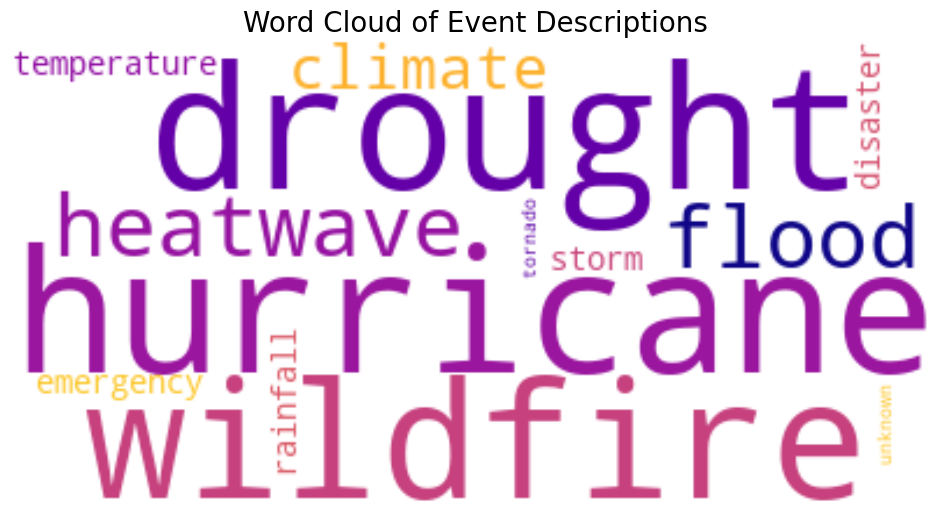

: 

In [ ]:
# 7.3. NLP Simulation (Simple WordCloud on Fake Descriptions)
# If you don't have event description, simulate
# some fake data for the sake of this example
# Simulate event descriptions
# Combine all event descriptions into a single string
words = [
    "hurricane", "flood", "wildfire", "heatwave", "drought", "storm", 
    "rainfall", "temperature", "climate", "disaster", "emergency"
]

# Generate fake descriptions based on the 'extremeweatherevent' column
df["event_description"] = df["extremeweatherevent"].apply(
    lambda event: " ".join(random.choices(words, k=random.randint(5, 10))) + f" {event.lower()}"
)

# Step 2: Combine all event descriptions into a single string
text = " ".join(desc for desc in df["event_description"])

# Step 3: Create WordCloud object
wordcloud = WordCloud(
    background_color="white",
    colormap="plasma",        # More vibrant color map
    max_words=100,
    contour_width=1,          # Optional: slight border around words
    contour_color='steelblue' # Optional: nice border color
).generate(text)

# Step 4: Plot the WordCloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Event Descriptions', fontsize=20)
plt.show()